In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download the COCO dataset
annotationfolder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotationfolder):
  annotationzip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotationfile = os.path.dirname(annotationzip)+'/annotations/captions_train2014.json'
  os.remove(annotationzip)

imagefolder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + imagefolder):
  imagezip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(imagezip) + imagefolder
  os.remove(imagezip)
else:
  PATH = os.path.abspath('.') + imagefolder

13510574080/13510573713 [==============================] - 326s 0us/step


In [0]:
with open(annotationfile, 'r') as f:
    annotations = json.load(f)

allcaptions = []
allimgnamevector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    imageid = annot['imageid']
    fullcocoimagepath = PATH + 'COCO_train2014_' + '%012d.jpg' % (imageid)

    allimgnamevector.append(fullcocoimagepath)
    allcaptions.append(caption)


traincaptions, imgnamevector = shuffle(allcaptions,
                                          allimgnamevector,
                                          random_state=1)

num_examples = 30000
traincaptions = traincaptions[:num_examples]
imgnamevector = imgnamevector[:num_examples]

In [0]:
with open(annotationfile, 'r') as f:
    annotations = json.load(f)

allcaptions = []
allimgnamevector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    imageid = annot['image_id']
    fullcocoimagepath = PATH + 'COCO_train2014_' + '%012d.jpg' % (imageid)

    allimgnamevector.append(fullcocoimagepath)
    allcaptions.append(caption)


traincaptions, imgnamevector = shuffle(allcaptions,
                                          allimgnamevector,
                                          random_state=1)

num_examples = 30000
traincaptions = traincaptions[:num_examples]
imgnamevector = imgnamevector[:num_examples]

In [6]:
len(traincaptions), len(allcaptions)

(30000, 414113)

In [0]:
def loadimage(imagepath):
    img = tf.io.read_file(imagepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, imagepath

In [8]:
imagemodel = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
newinput = imagemodel.input
hiddenlayer = imagemodel.layers[-1].output
imagefeaturesextractmodel = tf.keras.Model(newinput, hiddenlayer)

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
!pip install -q tqdm



In [0]:
from tqdm import tqdm



In [18]:
encodetrain = sorted(set(imgnamevector))

imagedataset = tf.data.Dataset.from_tensor_slices(encodetrain)
imagedataset = imagedataset.map(
  loadimage, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(imagedataset):
  batchfeatures = imagefeaturesextractmodel(img)
  batchfeatures = tf.reshape(batchfeatures,
                              (batchfeatures.shape[0], -1, batchfeatures.shape[3]))

  for bf, p in zip(batchfeatures, path):
    pathoffeature = p.numpy().decode("utf-8")
    np.save(pathoffeature, bf.numpy())

1622it [05:35,  4.84it/s]


In [0]:
def calcmaxlength(tensor):
    return max(len(t) for t in tensor)

In [0]:
topk = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=topk,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(traincaptions)
trainseqs = tokenizer.texts_to_sequences(traincaptions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
trainseqs = tokenizer.texts_to_sequences(traincaptions)

In [0]:

capvector = tf.keras.preprocessing.sequence.pad_sequences(trainseqs, padding='post')

In [0]:

capvector = tf.keras.preprocessing.sequence.pad_sequences(trainseqs, padding='post')

In [0]:
maxlength = calcmaxlength(trainseqs)

In [0]:
imgnametrain, imgnameval, captrain, capval = train_test_split(imgnamevector, capvector,test_size=0.2,random_state=0)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = topk + 1
num_steps = len(imgnametrain) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [0]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((imgnametrain, captrain))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
  
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [66]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9682
Epoch 1 Batch 100 Loss 1.0600
Epoch 1 Batch 200 Loss 0.9713
Epoch 1 Batch 300 Loss 0.9130
Epoch 1 Loss 1.039267
Time taken for 1 epoch 372.638635635376 sec

Epoch 2 Batch 0 Loss 0.8560
Epoch 2 Batch 100 Loss 0.8144
Epoch 2 Batch 200 Loss 0.8109
Epoch 2 Batch 300 Loss 0.7949
Epoch 2 Loss 0.792104
Time taken for 1 epoch 351.60348105430603 sec

Epoch 3 Batch 0 Loss 0.7807
Epoch 3 Batch 100 Loss 0.7932
Epoch 3 Batch 200 Loss 0.6919
Epoch 3 Batch 300 Loss 0.7123
Epoch 3 Loss 0.720652
Time taken for 1 epoch 348.6712975502014 sec

Epoch 4 Batch 0 Loss 0.6088
Epoch 4 Batch 100 Loss 0.7320
Epoch 4 Batch 200 Loss 0.6515
Epoch 4 Batch 300 Loss 0.6892
Epoch 4 Loss 0.675670
Time taken for 1 epoch 347.5991561412811 sec

Epoch 5 Batch 0 Loss 0.6487
Epoch 5 Batch 100 Loss 0.6270
Epoch 5 Batch 200 Loss 0.6319
Epoch 5 Batch 300 Loss 0.6279
Epoch 5 Loss 0.639270
Time taken for 1 epoch 346.8605818748474 sec

Epoch 6 Batch 0 Loss 0.5727
Epoch 6 Batch 100 Loss 0.5818
Epoch 6 Batc

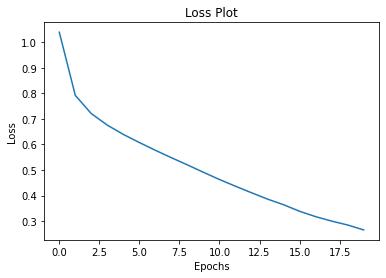

In [67]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
    attention_plot = np.zeros((maxlength, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(loadimage(image)[0], 0)
    img_tensor_val = imagefeaturesextractmodel(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(maxlength):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> some construction signs are on a wet road
 <end>
Prediction Caption: a yellow fire hydrant that are parked on the street with buildings in the day <end>


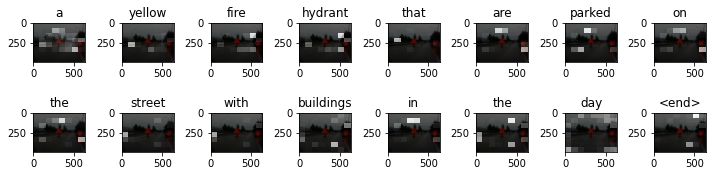

In [79]:
# captions on the validation set
rid = np.random.randint(0, len(imgnameval))
image = imgnameval[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in capval[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


65536/64400 [==============================] - 0s 1us/step
Prediction Caption: this man on a surf board on a clear bowl <end>


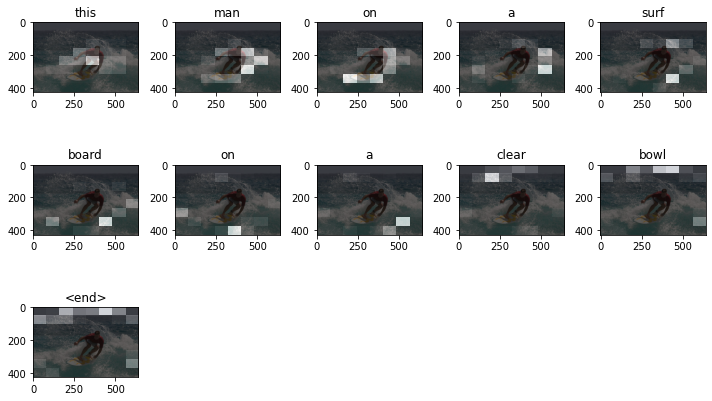

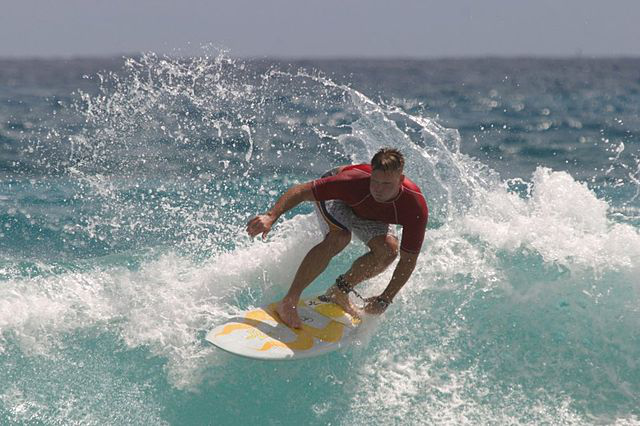

In [80]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a person rides the surf board rides a large body of the water <end>


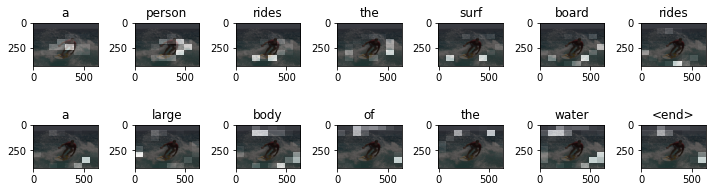

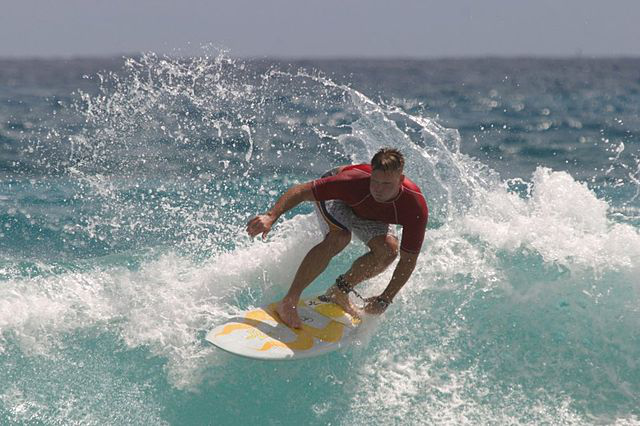

In [81]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)